Получаем данные

In [6]:
!wget "https://drive.google.com/uc?export=download&id=1mZRdUG_yBisy40VrNoB2yJAuinRmJ7FQ" -O 'data.zip'

--2021-02-28 05:41:29--  https://drive.google.com/uc?export=download&id=1mZRdUG_yBisy40VrNoB2yJAuinRmJ7FQ
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.102, 74.125.142.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dvruqucv9k53ch2nvn7rcgpabso5q1r7/1614490875000/00831264791388617636/*/1mZRdUG_yBisy40VrNoB2yJAuinRmJ7FQ?e=download [following]
--2021-02-28 05:41:30--  https://doc-04-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dvruqucv9k53ch2nvn7rcgpabso5q1r7/1614490875000/00831264791388617636/*/1mZRdUG_yBisy40VrNoB2yJAuinRmJ7FQ?e=download
Resolving doc-04-8k-docs.googleusercontent.com (doc-04-8k-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-04-8k-docs.googleusercontent.com (doc-04

In [7]:
import zipfile

zip = '/content/data.zip'
zip_un = zipfile.ZipFile(zip, 'r')
zip_un.extractall('/content/data/')
zip_un.close()
!rm /content/data.zip

In [8]:
!wget --random-wait -q -i /content/data/georges.csv -P /content/img/georges

In [9]:
!wget --random-wait -q -i /content/data/non_georges.csv -P /content/img/non_georges

In [10]:
!rm -r /content/data/

Визуализация изображений

In [11]:
import os

data_dir = '/content/img'

georges_data = os.path.join(data_dir, 'georges')
non_georges_data = os.path.join(data_dir, 'non_georges')


In [12]:
data_in = os.listdir(data_dir)

print('Общее количество изображений:')
for i in data_in:
  print(f'{i} : {len(os.listdir(os.path.join(data_dir, i)))}')

Общее количество изображений:
georges : 2681
non_georges : 3366


In [13]:
georges_names = os.listdir(georges_data)
non_georges_names = os.listdir(non_georges_data)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 2
ncols = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

pic_index += 4
georges_pic = [os.path.join(georges_data, fname) 
                for fname in georges_names[pic_index-4:pic_index]]
non_georges_pic = [os.path.join(non_georges_data, fname) 
                for fname in non_georges_names[pic_index-4:pic_index]]                                                             

for i, img_path in enumerate(georges_pic+non_georges_pic):
  sp = plt.subplot(nrows, ncols, i + 1)
  #sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Подготовка изображений. 

In [5]:
!pip install split-folders
import splitfolders

In [17]:
output = '/content/split_img'

splitfolders.ratio(data_dir, output=output, seed=47, ratio=(.8, .2))

Copying files: 6047 files [00:01, 3478.49 files/s]


In [20]:
train = '/content/split_img/train'
train_in = os.listdir(train)
val = '/content/split_img/val'
val_in = os.listdir(val)

print('Тренировочные изображения:')
for i in train_in:
  print(f'{i} : {len(os.listdir(os.path.join(train, i)))}')

print('Валидационные изображения:')
for i in val_in:
  print(f'{i} : {len(os.listdir(os.path.join(val, i)))}')  

Тренировочные изображения:
georges : 2144
non_georges : 2692
Валидационные изображения:
georges : 537
non_georges : 674


In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     zoom_range=0.3,
                                     fill_mode='nearest')    

train_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train,
                                                 target_size=(299, 299),
                                                 class_mode='binary')

val_generator = ImageDataGenerator(rescale=1/255)  

val_dataset = val_generator.flow_from_directory(batch_size=64,
                                                 directory=val,
                                                 target_size=(299, 299),
                                                 class_mode='binary')

Found 4557 images belonging to 2 classes.
Found 1143 images belonging to 2 classes.


Строим модель, используем предобученную модель InceptionV3

In [63]:
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

In [64]:
model_dense = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3)
)
last_output = model_dense.layers[-1].output
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dense(128, activation='linear')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
x = layers.Dropout(0.2)(x)                 
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(model_dense.input, x)

In [70]:
from tensorflow.keras.optimizers import Adam

for layers in model_dense.layers[-20:]:   # Замораживаем веса предтренированной модели, кроме последних 5
    layers.trainable = True             


model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.1),
              metrics=['accuracy'])

In [66]:
from keras.callbacks import ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000001)

In [71]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_473 (BatchN (None, 149, 149, 32) 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_473 (Activation)     (None, 149, 149, 32) 0           batch_normalization_473[0][0]    
____________________________________________________________________________________________

In [72]:
history = model.fit(train_dataset,
                    epochs = 13,
                    verbose = 1,
                    validation_data = val_dataset,
                    callbacks=[lr_reduction])

Epoch 1/20
143/143 [==============================] - 146s 990ms/step - loss: 0.6665 - accuracy: 0.7057 - val_loss: 0.4384 - val_accuracy: 0.8504
Epoch 2/20
143/143 [==============================] - 139s 976ms/step - loss: 0.3935 - accuracy: 0.8366 - val_loss: 0.4279 - val_accuracy: 0.8521
Epoch 3/20
143/143 [==============================] - 140s 977ms/step - loss: 0.3577 - accuracy: 0.8479 - val_loss: 0.4845 - val_accuracy: 0.8451

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
Epoch 4/20
143/143 [==============================] - 139s 968ms/step - loss: 0.2818 - accuracy: 0.8890 - val_loss: 0.2854 - val_accuracy: 0.8854
Epoch 5/20
143/143 [==============================] - 139s 970ms/step - loss: 0.2722 - accuracy: 0.8885 - val_loss: 0.2634 - val_accuracy: 0.8915
Epoch 6/20
143/143 [==============================] - 138s 968ms/step - loss: 0.2379 - accuracy: 0.8964 - val_loss: 0.2742 - val_accuracy: 0.8968
Epoch 7/20
143/143 [=========================

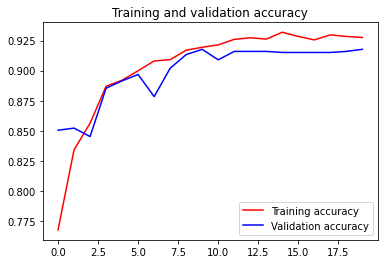

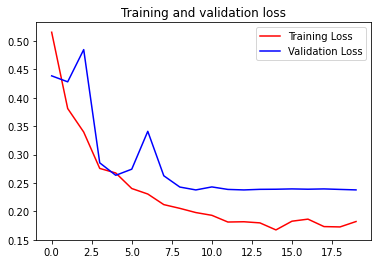

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:
norm_class = {v: k for k, v in train_dataset.class_indices.items()}
print(train_dataset.class_indices)
print(norm_class)

{'georges': 0, 'non_georges': 1}
{0: 'georges', 1: 'non_georges'}


In [ ]:
import numpy as np
from keras.preprocessing import image
import random
sample_path = os.path.join(georges_data, non_georges_data)
file_path =  os.listdir(os.path.join(georges_data, non_georges_data))
sample = random.choice(file_path)
test_image = image.load_img(os.path.join(sample_path, sample), target_size = (299, 299))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)


print("Это:",norm_class[np.argmax(result)])